In [198]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
fake_data1 = pd.read_csv("../data/Fake and real news dataset/Fake.csv")
true_data1 = pd.read_csv("../data/Fake and real news dataset/True.csv")

In [216]:
print("true_data1 dimensions:", true_data1.shape)
#true_data1.head()
print("fake_data1 dimensions:", fake_data1.shape)
#fake_data1.head()
#checking for invalid entries
print("true_data1 has null values:", true_data1.isnull().values.any())
print("fake_data1 has null values:", fake_data1.isnull().values.any())

true_data1 dimensions: (21417, 4)
fake_data1 dimensions: (23481, 4)
true_data1 has null values: False
fake_data1 has null values: False


False

In [202]:
#true_data1[['title', 'text']]
#fake_data1[['title', 'text']]

In [209]:
def plot_top_counts(titles, top, plt_title):
    unwanted = [ "to", "the", "for", "in", "of", "a", "and", "is", "says", "with", "as", "on", "at", "he", "his"]
    title_words = {}
    word = ""

    for title in titles:
        title = title.split(" ")

        for word in title:
            word = word.strip()
            word = word.strip(",")
            word = word.strip(".")
            word = word.strip("'")
            word = word.strip(":")
            word = word.lower()

            if word.isalpha() and (word not in unwanted):
                if word not in title_words:
                    title_words[word] = 1
                else:
                    title_words[word] += 1

    sorted_words = sorted(title_words.items(), key = lambda x: x[1], reverse = True)
    plotting_words = sorted_words[0:top]
    words_x = [tup[0] for tup in plotting_words]
    counts_y = [tup[1] for tup in plotting_words]

    
    
    plt.bar(range(len(plotting_words)), counts_y)
    plt.xticks(range(len(plotting_words)), words_x)
    plt.xlabel("Words")
    plt.ylabel("Counts")
    plt.title(plt_title)
    plt.show()




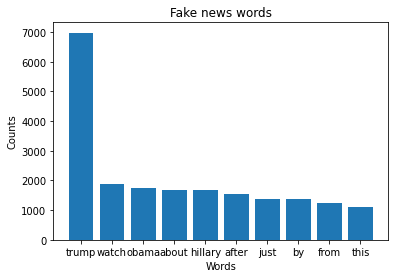

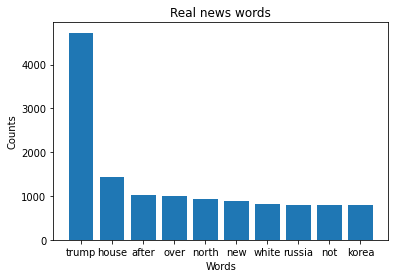

In [210]:
true_titles = true_data1['title']
fake_titles = fake_data1['title']
plot_top_counts(fake_titles, 10, "Fake news words")
plot_top_counts(true_titles, 10, "Real news words")
#write comment about hwo this data set is heavility based of articles from the US politiacal...

In [ ]:
#merging the fake and true datasets and adding a new column indicating where its fake or true

is_fake = [1 for x in range(len(fake_data1))]
fake_data1['is_fake'] = is_fake

is_fake = [0 for x in range(len(true_data1))]
true_data1['is_fake'] = is_fake

frames = [true_data1, fake_data1]
merged1 = pd.concat(frames)

merged1.describe
merged1 = sk.utils.shuffle(merged1)
merged1.head()

#splitting data into training and tests sets
split = 0.2
train_tles, test_tles, train_tles_res, test_tles_res = train_test_split(merged1['title'], merged1['is_fake'], test_size=split, random_state=12)
train_txts, test_txts, train_txts_res, test_txts_res = train_test_split(merged1['text'], merged1['is_fake'], test_size=split, random_state=12)

#print(len(train_txts))
#print(len(train_res_txts))
#print(len(test_tles))


In [ ]:
#creating a word dictionaries where each word is assigned a unique number 

#tokenizer for titles set
n_words = 10000
tokenizer_tles = tf.keras.preprocessing.text.Tokenizer(
    num_words = n_words, filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}\'~\t\n.', lower=True,
    split=' ', char_level=False,  oov_token=True)

tokenizer_tles.fit_on_texts(train_tles)
train_tles_seqs = tokenizer_tles.texts_to_sequences(train_tles)

max_tle_len = max(len(x) for x in train_tles_seqs)

train_tles_seqs = sequence.pad_sequences(train_tles_seqs, maxlen=max_tle_len)
test_tles_seqs = tokenizer_tles.texts_to_sequences(test_tles)
test_tles_seqs = sequence.pad_sequences(test_tles_seqs, maxlen=max_tle_len)



#tokenizer for texts set
tokenizer_txts = tf.keras.preprocessing.text.Tokenizer(
    num_words = n_words, filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}\'~\t\n.', lower=True,
    split=' ', char_level=False,  oov_token=True)

tokenizer_txts.fit_on_texts(train_txts)
train_txts_seqs = tokenizer_txts.texts_to_sequences(train_txts)

max_txt_len = max(len(x) for x in train_txts_seqs)

train_txts_seqs = sequence.pad_sequences(train_txts_seqs, maxlen=max_txt_len)
test_txts_seqs = tokenizer_txts.texts_to_sequences(test_txts)
test_txts_seqs = sequence.pad_sequences(test_txts_seqs, maxlen=max_txt_len)




In [ ]:

print(max_tle_len)

print(max_txt_len)


In [ ]:
print(max(tokenizer_tles.word_index.values()))
print(len(train_tles))


In [ ]:
#building model for analysing titles
#experiment with this 
inp_dim = max(tokenizer_tles.word_index.values()) + 1
out_dim = 24

model_tles = Sequential()
model_tles.add(Embedding(inp_dim, out_dim, input_length=max_tle_len))
model_tles.add(Flatten())
model_tles.add(Dense(8, activation='relu'))
model_tles.add(Dense(8, activation='relu'))
model_tles.add(Dense(1, activation='sigmoid'))
model_tles.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_tles.summary())

In [ ]:
print(len(train_tles_seqs))
print(len(train_tles_res))

In [ ]:
#fitting model for predicting if a title is part of a fake news article or not
hist_tles = model_tles.fit(train_tles_seqs, train_tles_res, validation_data=(test_tles_seqs, test_tles_res), epochs=3, batch_size=128)

In [ ]:
print(hist_tles.history.keys())

In [ ]:

#%matplotlib inline

sns.set()
acc = hist_tles.history['accuracy']
val = hist_tles.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

scores_tles = model_tles.evaluate(test_tles_seqs, test_tles_res, verbose=0)
print("Accuracy: %.2f%%" % (scores_tles[1] * 100))

In [ ]:
#building model for analysing texts
inp_dim = max(tokenizer_txts.word_index.values()) + 1
out_dim = 32

model_txts = Sequential()
model_txts.add(Embedding(inp_dim, out_dim, input_length=max_txt_len))
model_txts.add(Flatten())
model_txts.add(Dense(16, activation='relu'))
model_txts.add(Dense(16, activation='relu'))
model_txts.add(Dense(1, activation='sigmoid'))
model_txts.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_txts.summary())


In [ ]:
#fitting model for predicting a text/article body is fake or not
hist_txts = model_txts.fit(train_txts_seqs, train_txts_res, validation_data=(test_txts_seqs, test_txts_res), epochs=3, batch_size=512)

In [ ]:

#%matplotlib inline

sns.set()
acc = hist_txts.history['accuracy']
val = hist_txts.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

scores_tles = model_txts.evaluate(test_txts_seqs, test_txts_res, verbose=0)
print("Accuracy: %.2f%%" % (scores_tles[1] * 100))